<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function,
we will give you the code for this.

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [51]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving noor_content.jpg to noor_content (1).jpg

Upload Style Image


Saving style11.jpg to style11 (3).jpg
Content Path: <_io.BytesIO object at 0x7ea655413d30>
Style Path: <_io.BytesIO object at 0x7ea655e83010>


In [52]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


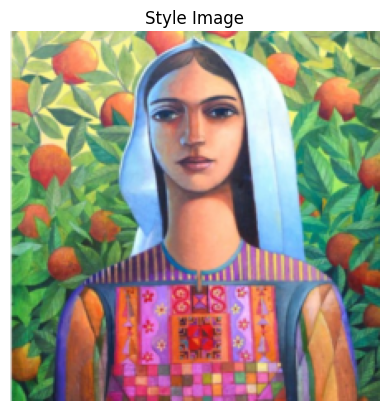

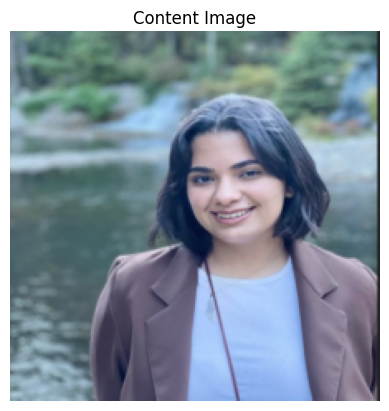

In [53]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    plt.axis('off')
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [54]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates

In [55]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
style_transfer_layers = [vgg_names.index('conv1_1'), vgg_names.index('conv2_1'), vgg_names.index('conv3_1'), vgg_names.index('conv4_1'), vgg_names.index('conv5_1')]
content_transfer_layers = [vgg_names.index('conv4_2')]

# print(style_transfer_layers)
# print(content_transfer_layers)

# Create the vgg network in eval mode
content_model = VGGIntermediate(requested=content_transfer_layers).cuda().eval()
style_model = VGGIntermediate(requested=style_transfer_layers).cuda().eval()

content_output = content_model(content_image)
style_output = style_model(style_image)

content_output = content_output[vgg_names.index('conv4_2')]


#  with our forward method that returns the outputs of the intermediate layers we requested

# Cache the outputs of the content and style layers for their respective images

<ipython-input-54-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-54-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavi

___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [56]:
import torch.nn.functional as F
# my_tensor = torch.randint(0,10, size = (2,2)).float()
# my_tensor2 = torch.tensor([[0,1],[1,2]])
# print(my_tensor)
# print(F.mse_loss(my_tensor, my_tensor2))

class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    return F.mse_loss(input, self.target)

def gram_matrix(input):
   a, b, c, d = input.size()

   features = input.view(a * b, c * d)

   G = torch.mm(features, features.t())

   return G.div(a * b * c * d)



class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target).detach()

  def forward(self, input):
    G = gram_matrix(input)
    return F.mse_loss(G, self.target)



# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison

content_loss_layers = ContentLoss(content_output.detach())

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
style_loss_layers = [StyleLoss(style_output[i]) for i in style_transfer_layers]





___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



100%|██████████| 300/300 [00:11<00:00, 25.57it/s]


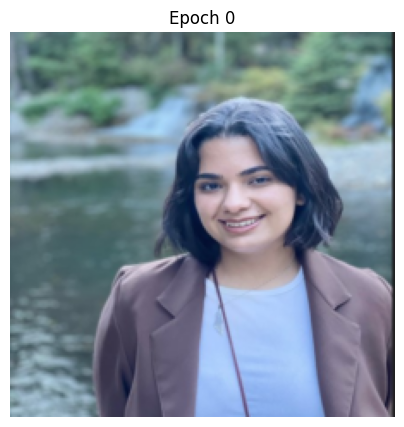

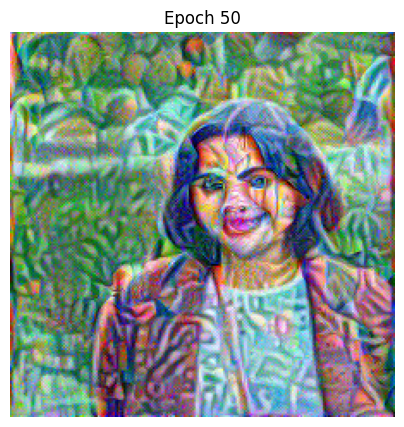

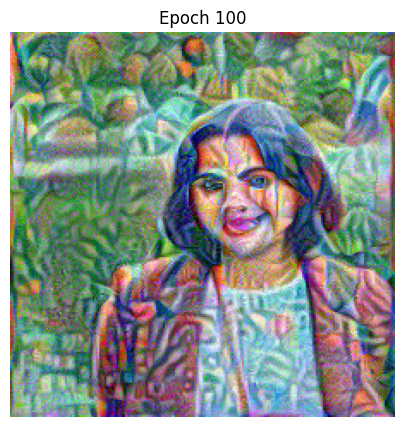

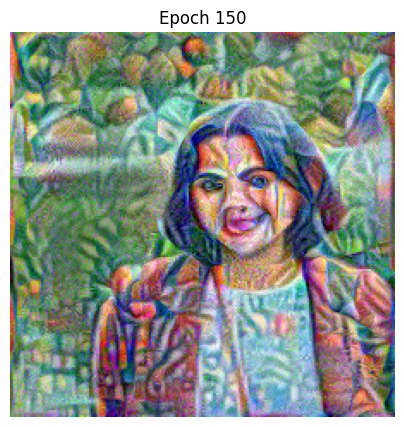

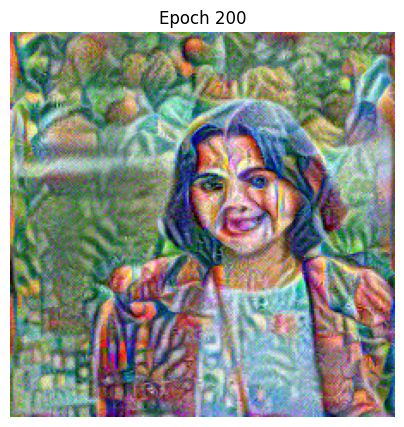

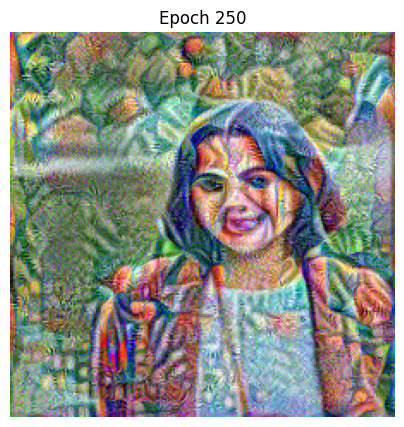

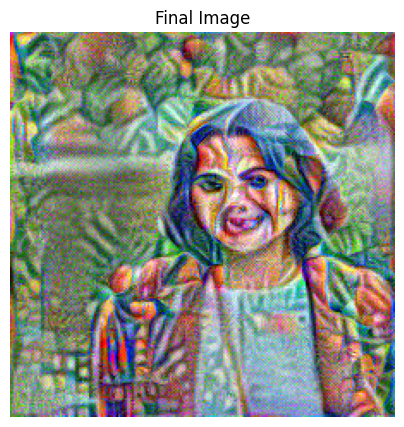

In [57]:
# Start with a copy of the content image
input_img = content_image.clone().requires_grad_(True).cuda()

optimizer = optim.Adam([input_img], lr=0.1)

num_epochs = 300
style_weight = 100000
content_weight = 1

loop = tqdm(total=num_epochs)

content_losses = []
style_losses = []


for epoch in range(num_epochs):

  content_output = content_model(input_img)
  style_output = style_model(input_img)

  content_loss = 0
  style_loss = 0

  for style in style_loss_layers:
    style_loss += style(style_output[style_transfer_layers[style_loss_layers.index(style)]])

  style_loss *= style_weight

  content_loss = content_loss_layers(content_output[vgg_names.index('conv4_2')])



  # Backward pass
  optimizer.zero_grad()
  content_loss.backward()
  style_loss.backward()


  # Clamp the image
  input_img.data.clamp_(0, 1)

  loop.update(1)

  # loop.set_description('Epoch {}/{}'.format(epoch, num_epochs))
  content_losses.append(content_loss.item())
  style_losses.append(style_loss.item())

  if epoch % 50 == 0:
    plt.figure(figsize=(5,5))
    display(input_img, title='Epoch {}'.format(epoch))

  optimizer.step()

loop.close()

input_img.data.clamp_(0, 1)
plt.figure(figsize=(5,5))
display(input_img, title='Final Image')



### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

1. Equation 1 is a calculation of the content loss by calculating the difference between the generated image X and the content image P at level l of the network. F and P are matrices with rows that corresponds to different channels and columns to different spatial loactions. MSE is used to calculate the loss. <br>
<br>
2. Equation 3 is a description of the Gram Matrix (G) It is caluclated from the feature matrix F at layerl l. Gij is calculated using the dot product of ith and jth vector of F. In general, it catches the correlations between the different feature maps (orginial style and generated style) at layer l. <br>
<br>
3. Equation 4 is the style loss for a single layer. It calculates the difference between the Gram Matrices of the A and G, which are the generated image and the style image at layer l. Loss is the MSE between the two gram matrices. N is the number of feature maps at layer l and M is the number of elements in each map at layerl l. <br>
<br>
4. Equation 5 is total style loss. A is a set of Gram matrices for the generated image over multiple layers, while G is the set for the style image. Wl is the weight for the contribution of layel l to the total loss. El is total loss at a specific layer. In general it gives the total loss by summing up the style losses at multiple layers.